<a href="https://colab.research.google.com/github/CodeArtificial/GAN-Celebrity/blob/main/GAN_Celebrity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm

In [ ]:
from PIL import Image

In [ ]:
def load_celebA(batch_size=32, train=True):
    dataset = []
    batch_counter = 0
    batch = []

    for file in tqdm(os.listdir('./celebA')):
        
        img = Image.open('./celebA/' + file).resize((89, 109))
        img = np.asarray(img).reshape(3, 109, 89)

        if batch_counter < batch_size:
            batch.append(img)
            batch_counter += 1
        else:
            dataset.append(np.array(batch))
            batch = []
            batch_counter = 0

    return np.array(dataset)

In [ ]:
def plot_image(image):
    image = image.reshape(-1, 109,89,3)

    plt.imshow(image[0])
    return

In [ ]:
# from google.colab import drive

# # drive.mount('/content/gdrive/')

# !unzip gdrive/My\ Drive/Spring_2022/CS389/HW4/celebA.zip

In [ ]:
dataset = load_celebA(batch_size=32, train=True)
dataset = torch.from_numpy(dataset)


100%|██████████| 40099/40099 [01:01<00:00, 656.49it/s]


image shape: torch.Size([32, 3, 109, 89])


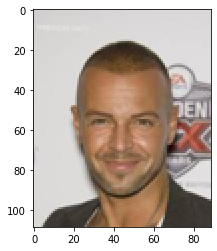

In [ ]:
ex_image = dataset[random.randint(0,100)]
print("image shape:", ex_image.shape)

plot_image(ex_image)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_shape, compression_size):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5 , kernel_size=3, stride=5)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=3, stride=5)
        out_cnn_size = 2 * 4 * 4
        self.lin3 = nn.Linear(out_cnn_size, compression_size)

        self.relu = nn.ReLU();
        self.flat = nn.Flatten();

    def forward(self, x):

        x = x.view(-1, 3, 109, 89).float()
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flat(x)
        x = self.lin3(x)
        out = x

        return out


In [ ]:
encoder = Encoder((3,109,89), 100)
test_out = encoder(ex_image)

print(test_out.shape)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_shape):
        super().__init__()
        self.output_shape = output_shape
        self.lin1 = nn.Linear(input_size, 29103)
        self.relu = nn.ReLU();
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        x = x.view(32, self.output_shape[0], self.output_shape[1], self.output_shape[2])
        out = x
        return out

In [ ]:
decoder = Decoder(100, (3,109,89))
test_out = decoder(torch.from_numpy(np.ones((32,100))).float())

print(test_out.shape)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_shape, compression_size):
        super().__init__()
        self.input_size = input_shape
        self.encoder = Encoder(input_shape, compression_size)
        self.decoder = Decoder(compression_size, input_shape)
        self.relu = nn.ReLU()
        
        
    def forward(self, features):
        out = self.encoder(features)
        out = self.relu(out)
        out = self.decoder(out)
        return out

The original image


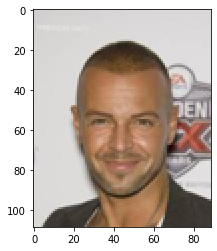

Your reconstruction


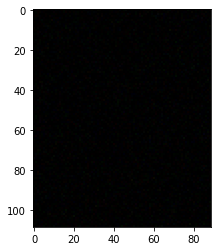

In [ ]:
input_shape = (3,109,89)

test_model = Autoencoder(input_shape, 100)
test_output = test_model(ex_image)

print("The original image")
plot_image(ex_image.byte())
plt.show()
print("Your reconstruction")
plot_image(test_output.detach().byte())

In [ ]:
model = Autoencoder(input_shape, 100)
ex_image = ex_image.float().view(-1,3,109,89)                               

loss_function = nn.MSELoss()                           
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("BEFORE GRADIENT STEP:")
ex_pred = model(ex_image)
ex_label = ex_image


optimizer.zero_grad()

ex_loss1 = loss_function(ex_pred, ex_label)
print("loss",ex_loss1.item())

ex_loss1.backward()

print()
print("AFTER GRADIENT STEP:")
optimizer.step()

ex_pred = model(ex_image)
ex_label = ex_image

ex_loss2 = loss_function(ex_pred, ex_label)
print("loss",ex_loss2.item())

print()
print("Difference in loss:", (ex_loss1 - ex_loss2).item())
print("This should be some positive number to say we reduced loss")

BEFORE GRADIENT STEP:
loss 18991.216796875

AFTER GRADIENT STEP:
loss 16718.6015625

Difference in loss: 2272.615234375
This should be some positive number to say we reduced loss


In [ ]:
def autoencoder_training(model, loss_function, optimizer, train_data, n_epochs, update_interval):
    losses = []

    for n in range(n_epochs):
        for i, image in enumerate(tqdm(train_data)):

            image = image.float().view(-1,3,109,89)

            for j in range(n_epochs):
                for input in train_data:
                    optimizer.zero_grad()
                    my_output = model(input)
                    loss = loss_function(my_output, image)
                    loss.backward()
                    optimizer.step()
        
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2))
        
    return model, losses



100%|██████████| 100/100 [11:57<00:00,  7.18s/it]


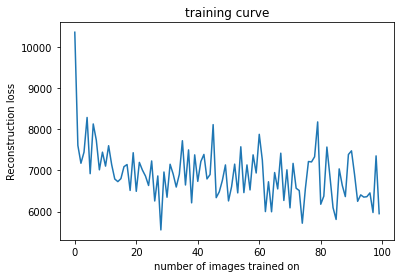

In [ ]:
lr = 1e-4
batch_size = 1
update_interval = 1
n_epochs = 1
compression_size = 100

input_shape = (3,109,89)

dataset = dataset[:100]

model = Autoencoder(input_shape, compression_size) 
loss_function = nn.MSELoss()                        
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 

trained_model, losses = autoencoder_training(model, loss_function, optimizer, dataset, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("Reconstruction loss")
plt.show()

original image:


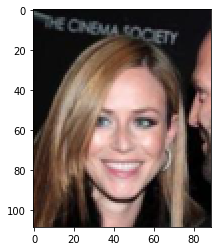

your (trained) reconstruction


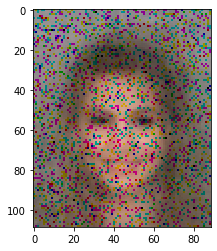

In [ ]:
ex_image = dataset[random.randint(0,100)]
trained_output = trained_model(ex_image)

print("original image:")
plot_image(ex_image)
plt.show()
print("your (trained) reconstruction")
plot_image(trained_output.detach().byte())

In [ ]:
def testing(model, loss_function, test_data):
    sum_loss = 0

    for i, image in enumerate(tqdm(test_data)):
        pred = model(image)
        loss = loss_function(pred, image)
        sum_loss += loss.item()
    
    avg_loss = round(sum_loss / len(test_data), 2)

    print("test loss:", avg_loss )

    return avg_loss

def train_and_test(model, loss_function, optimizer, batch_size, update_interval, n_epochs):
    train_dataset = dataset[:30000//batch_size]
    test_dataset = dataset[:30000//batch_size]

    trained_model, losses = autoencoder_training(model, loss_function, optimizer, train_dataset, n_epochs=n_epochs, update_interval=update_interval)

    test_loss = testing(trained_model, loss_function, test_dataset)

    plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, color="b", label="train loss")
    plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss")
    plt.legend()
    plt.title("training curve")
    plt.xlabel("number of images trained on")
    plt.ylabel("loss")
    plt.show()

    return trained_model, test_loss

In [ ]:
avg_test_loss = testing(trained_model, loss_function, dataset[1:])
print(avg_test_loss)

100%|██████████| 99/99 [00:01<00:00, 82.16it/s]

test loss: 6672.96
6672.96


In [ ]:
def randomsearch(input_shape, loss_function):
    best_model = None
    prev_loss = float("infinity")
    learning_rate_out = None
    update_interval_out = None
    n_epochs_out = None
    compression_size_out = None
    
    for learning_rate in [1e-8, 1e-6, 1e-4]:
        for update_interval in range(1, 101):
            for n_epochs in range (1, 11):
                for compression_size in range(100, 1001):
                  model = Autoencoder(input_shape,compression_size)
                  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                  curr_model, test_loss = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)
                  if test_loss < prev_loss:
                    prev_loss = test_loss
                    best_model = curr_model
                    learning_rate_out = learning_rate
                    update_interval_out = update_interval
                    n_epochs_out = n_epochs
                    compression_size_out = compression_size

    return best_model, prev_loss, learning_rate_out, update_interval_out, n_epochs_out, compression_size_out

100%|██████████| 100/100 [00:01<00:00, 65.84it/s]


test loss: 18251.57


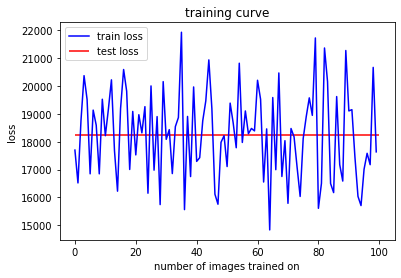

100%|██████████| 100/100 [00:01<00:00, 81.13it/s]


test loss: 18237.71


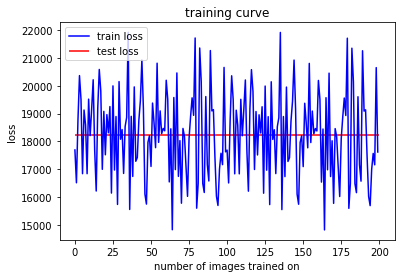

100%|██████████| 100/100 [00:01<00:00, 82.47it/s]


test loss: 18201.85


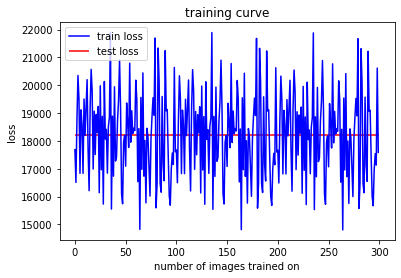

100%|██████████| 100/100 [00:01<00:00, 75.92it/s]


test loss: 18118.01


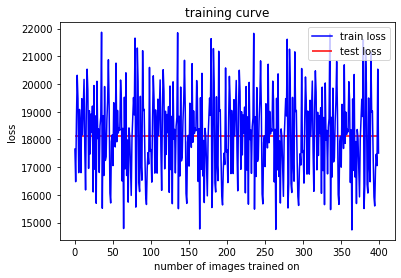

 41%|████      | 41/100 [16:20<23:28, 23.88s/it]

In [ ]:
# lr = 1e-4 
# batch_size = 1
# update_interval = 1 
# n_epochs = 1 
# compression_size = 100 

# model = Autoencoder(input_shape, compression_size)
loss_function = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# best_model, _ = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)

best_model, prev_loss, learning_rate_out, update_interval_out, n_epochs_out, compression_size_out = randomsearch(input_shape, loss_function)

ex_image = dataset[random.randint(0,100)]
trained_output = trained_model(ex_image)

print("original image:")
plot_image(ex_image)
plt.show()
print("your (BEST) reconstruction")
plot_image(trained_output.detach().byte())

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5 , kernel_size=3, stride=5)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=3, stride=5)
        out_cnn_size = 2 * 4 * 4
        self.lin3 = nn.Linear(out_cnn_size, 1)    
        self.relu = nn.ReLU();
        self.flat = nn.Flatten();


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flat(x)
        x = self.lin3(x)
        out = x

        x = nn.Sigmoid()(x)

        return x


Output of the discriminator given this input: 0.046097435


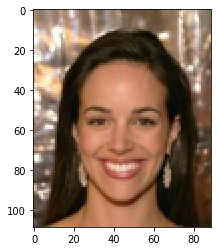

In [ ]:
discriminator = Discriminator((3,109,89))
ex_output = discriminator(ex_image.float())

plot_image(ex_image)
print("Output of the discriminator given this input:", ex_output[0].detach().numpy()[0])

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, output_shape):
        super(Generator, self).__init__()

        self.input_size = input_size
        self.output_shape = output_shape

        self.lin1 = nn.Linear(input_size, 29103)
        self.conv2 = nn.Conv2d(in_channels=1,out_channels=1, kernel_size=self.input_size, stride=5)
        self.conv3 = nn.Conv2d(in_channels=5, out_channels=3, kernel_size=3, stride=5)

        self.relu = nn.ReLU();
        self.flat =  nn.Flatten();

    def forward(self, x):
        x = self.lin1(x)
        x = self.relu(x)
        x = x.view(x.size(0), self.output_shape[0], self.output_shape[1], self.output_shape[2])

        out = x
        print(x.shape)


        return nn.Sigmoid()(x)

torch.Size([1, 128])
torch.Size([1, 3, 109, 89])


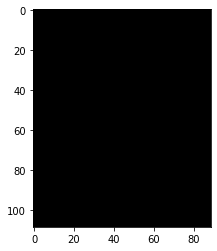

In [ ]:
test_gen = Generator(128, (3, 109, 89))
noise = (torch.rand(1, 128) - 0.5) / 0.5
test_output = test_gen(noise)

plot_image(test_output.detach().byte())

In [ ]:
def training(generator, discriminator, loss, g_optimizer, d_optimizer, train_dataloader, n_epochs, update_interval, noise_samples):
    
    g_losses = []
    d_losses = []
    
    for epoch in range(n_epochs):
        for i, image in enumerate(tqdm(train_dataloader)):
            image = image.float()
            
            real_classifications = discriminator(image)
            
            real_labels = torch.ones(image.shape[0])

            noise = torch.from_numpy((np.random.randn(image.shape[0], noise_samples) - 0.5) / 0.5).float()  ## This is us sampling gaussian noise
            
            fake_inputs = generator(noise)
            
            fake_classifications = discriminator(fake_inputs)   

            fake_labels = torch.zeros(image.shape[0])
            classifications = torch.cat((real_classifications, fake_classifications), 0).reshape(len(real_classifications) + len(fake_classifications))
            targets = torch.cat((real_labels, fake_labels), 0)


            for j in range(n_epochs):
                for input in train_dataloader:
                    d_optimizer.zero_grad()
                    my_output = fake_inputs
                    d_loss = loss(my_output, image)
                    d_loss.backward(retain_graph=True)
                    optimizer.step()
            
            if i % update_interval == 0:
                d_losses.append(round(d_loss.item(), 2))

            noise = torch.from_numpy((np.random.randn(image.shape[0], noise_samples) - 0.5) / 0.5).float()
            fake_inputs = generator(noise)
            fake_classifications = discriminator(fake_inputs)
            fake_labels = torch.zeros(image.shape[0], 1)

            for i in range(n_epochs):
                for input in train_dataloader:
                    g_optimizer.zero_grad()
                    my_output = fake_classifications
                    g_loss = loss(my_output, fake_labels)
                    g_loss.backward(retain_graph=True)
                    optimizer.step()

            if i % update_interval == 0:
                g_losses.append(round(g_loss.item(), 2))
                
    return (generator, discriminator), (g_losses, d_losses) 

In [ ]:
def randomsearch_1(loss, data):
    best_gen_model = None
    best_dis_model = None
    prev_gen_loss = float("infinity")
    prev_dis_loss = float("infinity")
    learning_rate_out = None
    update_interval_out = None
    n_epochs_out = None
    noise_samples_out = None
    
    for learning_rate in [1e-8, 1e-6, 1e-4]:
        for update_interval in range(1, 101):
            for n_epochs in range (1, 11):
                for noise_samples in range(100, 1001):

                    generator = Generator(noise_samples, (3, 109, 89))
                    discriminator = Discriminator((3, 109, 89))
                    generator_op = torch.optim.Adam(generator.parameters(), lr=lr)
                    discriminator_op = torch.optim.Adam(discriminator.parameters(), lr=lr)
                    curr_models, test_losses = training(generator, discriminator, loss, generator_op, discriminator_op, data, n_epochs=n_epochs, update_interval=update_interval, noise_samples=noise_samples)
                    g_losses, d_losses = test_losses
                    if (np.mean(g_losses) < np.mean(prev_gen_loss)) or (np.mean(d_losses) < np.mean(prev_dis_loss)):
                        prev_gen_loss = g_losses
                        prev_dis_loss = d_losses
                        best_gen_model, best_dis_model = curr_models
                        learning_rate_out = learning_rate
                        update_interval_out = update_interval
                        n_epochs_out = n_epochs
                        noise_samples_out = noise_samples

    return (best_gen_model, best_dis_model), (g_losses, d_losses), learning_rate_out, update_interval_out, n_epochs_out, noise_samples_out


  0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  1%|          | 1/100 [00:14<24:16, 14.71s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  2%|▏         | 2/100 [00:29<23:37, 14.47s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  3%|▎         | 3/100 [00:43<23:03, 14.27s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  4%|▍         | 4/100 [00:57<22:44, 14.21s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  5%|▌         | 5/100 [01:11<22:45, 14.37s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  6%|▌         | 6/100 [01:26<22:31, 14.38s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  7%|▋         | 7/100 [01:40<22:20, 14.41s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  8%|▊         | 8/100 [01:54<22:00, 14.36s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


  9%|▉         | 9/100 [02:09<21:43, 14.32s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 10%|█         | 10/100 [02:23<21:28, 14.31s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 11%|█         | 11/100 [02:37<21:11, 14.29s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 12%|█▏        | 12/100 [02:52<20:57, 14.29s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 13%|█▎        | 13/100 [03:06<20:40, 14.26s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 14%|█▍        | 14/100 [03:20<20:36, 14.38s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 15%|█▌        | 15/100 [03:34<20:13, 14.28s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 16%|█▌        | 16/100 [03:49<19:58, 14.27s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 17%|█▋        | 17/100 [04:03<19:47, 14.30s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 18%|█▊        | 18/100 [04:18<19:43, 14.43s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 19%|█▉        | 19/100 [04:32<19:22, 14.36s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 20%|██        | 20/100 [04:46<19:07, 14.34s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 21%|██        | 21/100 [05:00<18:45, 14.25s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 22%|██▏       | 22/100 [05:15<18:32, 14.27s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 23%|██▎       | 23/100 [05:29<18:21, 14.31s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 24%|██▍       | 24/100 [05:43<18:03, 14.26s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 25%|██▌       | 25/100 [05:57<17:46, 14.21s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 26%|██▌       | 26/100 [06:11<17:28, 14.16s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 27%|██▋       | 27/100 [06:26<17:29, 14.38s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 28%|██▊       | 28/100 [06:40<17:08, 14.28s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 29%|██▉       | 29/100 [06:54<16:50, 14.23s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 30%|███       | 30/100 [07:09<16:36, 14.23s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 31%|███       | 31/100 [07:23<16:35, 14.42s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 32%|███▏      | 32/100 [07:38<16:18, 14.39s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 33%|███▎      | 33/100 [07:52<16:08, 14.46s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 34%|███▍      | 34/100 [08:06<15:47, 14.36s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 35%|███▌      | 35/100 [08:21<15:39, 14.45s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 36%|███▌      | 36/100 [08:35<15:21, 14.40s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 37%|███▋      | 37/100 [08:50<15:13, 14.49s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 38%|███▊      | 38/100 [09:05<15:00, 14.52s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 39%|███▉      | 39/100 [09:19<14:44, 14.49s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 40%|████      | 40/100 [09:34<14:28, 14.47s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 41%|████      | 41/100 [09:48<14:16, 14.52s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 42%|████▏     | 42/100 [10:03<14:05, 14.58s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 43%|████▎     | 43/100 [10:18<13:55, 14.67s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 44%|████▍     | 44/100 [10:33<13:47, 14.77s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 45%|████▌     | 45/100 [10:47<13:27, 14.69s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 46%|████▌     | 46/100 [11:02<13:11, 14.65s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 47%|████▋     | 47/100 [11:17<13:00, 14.72s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 48%|████▊     | 48/100 [11:31<12:41, 14.64s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 49%|████▉     | 49/100 [11:45<12:18, 14.48s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 50%|█████     | 50/100 [11:59<11:58, 14.37s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 51%|█████     | 51/100 [12:14<11:40, 14.30s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 52%|█████▏    | 52/100 [12:28<11:28, 14.35s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 53%|█████▎    | 53/100 [12:42<11:14, 14.36s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 54%|█████▍    | 54/100 [12:57<11:01, 14.38s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 55%|█████▌    | 55/100 [13:11<10:46, 14.37s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 56%|█████▌    | 56/100 [13:26<10:36, 14.47s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 57%|█████▋    | 57/100 [13:40<10:19, 14.40s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 58%|█████▊    | 58/100 [13:54<10:02, 14.33s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 59%|█████▉    | 59/100 [14:08<09:45, 14.28s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 60%|██████    | 60/100 [14:24<09:41, 14.54s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 61%|██████    | 61/100 [14:38<09:24, 14.48s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 62%|██████▏   | 62/100 [14:52<09:09, 14.47s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 63%|██████▎   | 63/100 [15:07<08:53, 14.43s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 64%|██████▍   | 64/100 [15:21<08:39, 14.42s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 65%|██████▌   | 65/100 [15:36<08:24, 14.41s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 66%|██████▌   | 66/100 [15:50<08:09, 14.39s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 67%|██████▋   | 67/100 [16:04<07:56, 14.44s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 68%|██████▊   | 68/100 [16:19<07:40, 14.40s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 69%|██████▉   | 69/100 [16:33<07:25, 14.39s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 70%|███████   | 70/100 [16:48<07:12, 14.42s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 71%|███████   | 71/100 [17:02<07:01, 14.55s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 72%|███████▏  | 72/100 [17:17<06:48, 14.59s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 73%|███████▎  | 73/100 [17:32<06:32, 14.55s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 74%|███████▍  | 74/100 [17:46<06:18, 14.54s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 75%|███████▌  | 75/100 [18:01<06:08, 14.75s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 76%|███████▌  | 76/100 [18:16<05:54, 14.75s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 77%|███████▋  | 77/100 [18:31<05:39, 14.77s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 78%|███████▊  | 78/100 [18:46<05:25, 14.78s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 79%|███████▉  | 79/100 [19:01<05:14, 14.98s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 80%|████████  | 80/100 [19:16<05:00, 15.00s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 81%|████████  | 81/100 [19:31<04:43, 14.93s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 82%|████████▏ | 82/100 [19:46<04:29, 15.00s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 83%|████████▎ | 83/100 [20:01<04:15, 15.05s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 84%|████████▍ | 84/100 [20:17<04:02, 15.15s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 85%|████████▌ | 85/100 [20:32<03:49, 15.29s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 86%|████████▌ | 86/100 [20:48<03:35, 15.41s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 87%|████████▋ | 87/100 [21:03<03:20, 15.40s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 88%|████████▊ | 88/100 [21:19<03:05, 15.45s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 89%|████████▉ | 89/100 [21:34<02:49, 15.45s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 90%|█████████ | 90/100 [21:50<02:35, 15.53s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 91%|█████████ | 91/100 [22:06<02:20, 15.63s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 92%|█████████▏| 92/100 [22:22<02:06, 15.87s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 93%|█████████▎| 93/100 [22:39<01:51, 15.97s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 94%|█████████▍| 94/100 [22:55<01:37, 16.18s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 95%|█████████▌| 95/100 [23:12<01:21, 16.28s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 96%|█████████▌| 96/100 [23:29<01:05, 16.49s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 97%|█████████▋| 97/100 [23:45<00:49, 16.50s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 98%|█████████▊| 98/100 [24:03<00:33, 16.72s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


 99%|█████████▉| 99/100 [24:20<00:17, 17.06s/it]

torch.Size([32, 128])
torch.Size([32, 3, 109, 89])
32
torch.Size([32, 128])
torch.Size([32, 3, 109, 89])


100%|██████████| 100/100 [24:38<00:00, 14.78s/it]


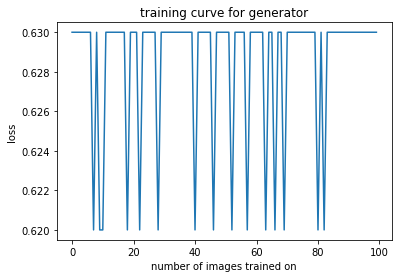

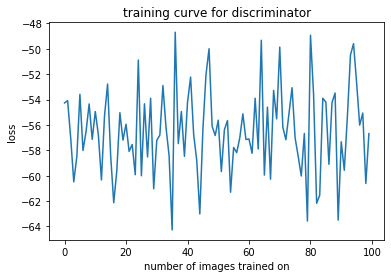

In [ ]:
# lr = 2e-5
# batch_size = 64
# update_interval = 100
# n_epochs = 1
# noise_samples = 128

loss_function = nn.BCELoss()

# G_model = Generator(noise_samples, (3,109,89))
# D_model = Discriminator((3,109,89))
# G_optimizer = torch.optim.Adam(G_model.parameters(), lr=lr)
# D_optimizer = torch.optim.Adam(D_model.parameters(), lr=lr)     

train_dataset = dataset

# models, losses = training(G_model, D_model, loss_function, G_optimizer, D_optimizer, train_dataset, n_epochs, update_interval, noise_samples)

models, losses, learning_rate_out, update_interval_out, n_epochs, noise_samples_out = randomsearch_1(loss_function, train_dataset)

G_model, D_model = models
g_losses, d_losses = losses

plt.plot(np.arange(len(g_losses)) * batch_size * update_interval, g_losses)
plt.title("training curve for generator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

plt.plot(np.arange(len(d_losses)) * batch_size * update_interval, d_losses)
plt.title("training curve for discriminator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

Output of the discriminator given this input: 1.1884765e-15


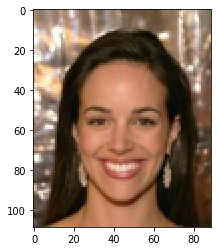

torch.Size([1, 128])
torch.Size([1, 3, 109, 89])
Output of the discriminator given this generated input: 0.4772479


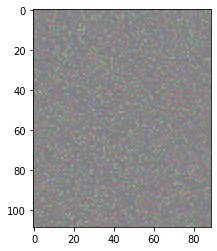

In [ ]:
trained_output = D_model(ex_image.float())

plot_image(ex_image)
print("Output of the discriminator given this input:", trained_output[0].detach().numpy()[0])
plt.show()

noise = (torch.rand(1, G_model.input_size) - 0.5) / 0.5
trained_gen = G_model(noise)

plot_image(trained_gen.detach())

trained_output = D_model(trained_gen.float())

print("Output of the discriminator given this generated input:", trained_output[0].detach().numpy()[0])

In [ ]:
def randomsearch_1(loss, data):
    best_gen_model = None
    best_dis_model = None
    prev_gen_loss = float("infinity")
    prev_dis_loss = float("infinity")
    learning_rate_out = None
    update_interval_out = None
    n_epochs_out = None
    noise_samples_out = None

    for learning_rate in [1e-8, 1e-6, 1e-4]:
        for update_interval in range(1, 101):
            for n_epochs in range (1, 11):
                for noise_samples in range(100, 1001):
                    generator = Generator(noise_samples, (3, 109, 89))
                    discriminator = Discriminator((3, 109, 89))
                    generator_op = torch.optim.Adam(generator.parameters(), lr=lr)
                    discriminator_op = torch.optim.Adam(discriminator.parameters(), lr=lr)
                    curr_models, test_losses = training(generator, discriminator, loss, generator_op, discriminator_op, data, n_epochs=n_epochs, update_interval=update_interval, noise_samples=noise_samples)
                    g_losses, d_losses = test_losses
                    if (np.mean(g_losses) < np.mean(prev_gen_loss)) or (np.mean(d_losses) < np.mean(prev_dis_loss)):
                        prev_gen_loss = g_losses
                        prev_dis_loss = d_losses
                        best_gen_model, best_dis_model = curr_models
                        learning_rate_out = learning_rate
                        update_interval_out = update_interval
                        n_epochs_out = n_epochs
                        noise_samples_out = noise_samples

    return (best_gen_model, best_dis_model), (g_losses, d_losses), learning_rate_out, update_interval_out, n_epochs_out, noise_samples_out

torch.Size([1, 128])
torch.Size([1, 3, 109, 89])


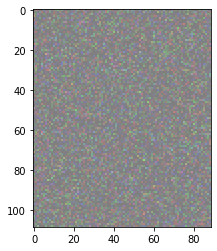

In [ ]:
noise = (torch.rand(1, 128) - 0.5) / 0.5
trained_output = G_model(noise)

plot_image(trained_output.detach())